In [ ]:
import pennylane as qml
from pennylane.resource import SpectralNormError

exact_op = qml.RX(1.234, wires=0)

print(exact_op)
thetas = [1.23, 1.2, 1.0]
ops = [qml.RX(theta, wires=0) for theta in thetas]

for approx_op, theta in zip(ops, thetas):
    error = SpectralNormError.get_error(exact_op, approx_op)
    print(f"Spectral Norm error (theta = {theta:.2f}): {error:.5f}")

In [ ]:
import numpy as np
from pyscf import gto, scf, fci

#H4 = 'H; H 1 2.0; H 1 2.0 2 {}; H 2 2.0 1 {} 3 0.0'

#Define a function to calculate the energy for a given bond length
def calculate_energy(bond_angle):
    mol = gto.M(
        atom = "H 0 0 0; H 0 0 1.5;H 0 1.5 0; H 0 1.5 1.5",
        basis = 'sto3g'
    )
    mf = scf.RHF(mol)
    mf.kernel()
    cisolver = fci.FCI(mf)
    e, _ = cisolver.kernel()
    return e

energies = []

# Define the range of bond lengths to calculate the PES
bond_angles = np.arange(65, 101, 1.0)
energies = []

# Calculate the energy for each bond length
for bond_angle in bond_angles:
    energy = calculate_energy(bond_angle)
    energies.append(energy)
    print(f'Bond Angle: {bond_angle:.2f} Å, Energy: {energy:.6f} Hartree')

# Optionally, plot the PES
try:
    import matplotlib.pyplot as plt
    plt.plot(bond_angles, energies, '-o')
    plt.xlabel('Bond length (Å)')
    plt.ylabel('Energy (Hartree)')
    plt.title('PES of H4 (STO-3G, Full CI)')
    plt.show()
except ImportError:
    print("Matplotlib is not installed. Skipping plot.")

print(np.min(energies)) 

In [ ]:
import numpy as np
qubits = 4
def measure_readout_error(dev):
    """Measure readout confusion matrix for each qubit."""
    n = len(dev.wires)
    confusion_matrices = []
    
    for w in range(n):
        # Prepare |0⟩
        @qml.qnode(dev)
        def measure_zero():
            qml.BasisState([0], wires=[w])
            return qml.sample(qml.PauliZ(w))

        # Prepare |1⟩
        @qml.qnode(dev)
        def measure_one():
            qml.BasisState([1], wires=[w])
            return qml.sample(qml.PauliZ(w))

        z0 = measure_zero()
        z1 = measure_one()
        
        # Convert ±1 results to bit values
        bits0 = (1 - z0) // 2
        bits1 = (1 - z1) // 2
        
        # Compute confusion matrix entries
        p00 = np.mean(bits0 == 0)
        p11 = np.mean(bits1 == 1)
        p01 = 1 - p11
        p10 = 1 - p00
        
        M = np.array([[p00, p01],
                      [p10, p11]])
        confusion_matrices.append(M)
    
    return confusion_matrices


In [ ]:
dev = qml.device("default.qubit", wires=qubits, shots=10000)
conf_matrices = measure_readout_error(dev)
print("Readout confusion matrices per qubit:", conf_matrices)


In [ ]:
import numpy as np
from pyscf import gto, scf, fci

# Define a function to calculate the energy for a given bond angle
def calculate_energies(bond_angle, nroots=5):  # nroots includes ground + excited states
    # Define the molecule with the desired geometry (modify this as needed)
    mol = gto.M(
        atom = f"N 0.0 0.0 0.0; H 0.0 0.0 1.40; H 0.0 0.6 -0.3360; H 0.6 0.0 -0.3360",  # Update for the desired geometry
        basis = 'sto3g'
    )
    
    # Perform the SCF calculation (mean-field)
    mf = scf.RHF(mol)
    mf.kernel()

    # Perform Full Configuration Interaction (FCI) to solve for all states
    cisolver = fci.FCI(mf)

    # Compute both the ground state and excited state energies
    e, evec = cisolver.kernel(nroots=nroots)  # nroots specifies how many states to calculate (ground + excited)
    
    # `e` contains the energies of the ground state and all excited states
    return e

# Define the range of bond angles to calculate the PES
bond_angles = np.arange(65, 66,1.0)

# Store energies for each bond angle
energies = []

# Calculate the energies for each bond angle
for bond_angle in bond_angles:
    energies_at_angle = calculate_energies(bond_angle, nroots=25)  # Change nroots to compute more excited states
    print(f'Bond Angle: {bond_angle:.2f} Å')
    for i, energy in enumerate(energies_at_angle):
        print(f'  State {i}: {energy:.6f} Hartree')
    energies.append(energies_at_angle)

# Optionally, plot the PES of the ground state and excited states

import matplotlib.pyplot as plt
# Extract energies for all states for plotting
all_energies = np.array(energies)

# Plot energies for all states
for i in range(all_energies.shape[1]):  # Loop over each state
    plt.plot(bond_angles, all_energies[:, i], '-o', label=f'State {i}')

plt.xlabel('Bond Angle (°)')
plt.ylabel('Energy (Hartree)')
plt.title('PES of H4 (STO-3G, Full CI)')
plt.legend()
plt.show()
print(energies)

## Excited state

In [ ]:
#code for calculating FCI for excited states 
 
from pyscf import gto, scf, mcscf
import numpy as np
bond_lengths = np.linspace(1.6, 2.35, 16)
# Define the molecule
for r in bond_lengths:
    mol = gto.M(
        atom = f"H 0.0 0.0 0.0; H 0.0 0.0 1.5; H {r} 0.0 0.0; H {r} 0.0 1.5",
        basis='sto-3g',
        verbose=1  # Optional: Adjusts verbosity for output
    )


    # Perform Restricted Hartree-Fock calculation
    mf = scf.RHF(mol)
    mf.kernel()

    # Get the HF energy
    hf_energy = mf.e_tot
    #print("Hartree-Fock Energy:", hf_energy)

    # Define the active space
    active_orbitals = 4  # Number of active orbitals - spatial it seems
    active_electrons = 4 # Number of electrons in the active space

    # Set up the CASCI/CASSCF solver
    mycas = mcscf.CASCI(mf, active_orbitals, active_electrons)

    mycas.fcisolver.nroots=10

    # Compute the CASCI/CASSCF energy
    e_casci = mycas.kernel()
    #print('summa', e_casci)
    all_energies = e_casci[0:1]
    #energy = np.array([np.squeeze(row) for row in excited_energies])
    energy = np.array([entry[0:] for entry in all_energies])
    # Output the results
    print(f"Computing for bond length: { r:.2f} Å")
    print(f"Eigenvalues:", energy[:, 0])

Bond length 0.60 Å - CASCI energies: [-55.51966204 -55.06435283 -54.98075721 -54.97111366 -54.94469435
 -54.80102048 -54.73953515 -54.66907147 -54.50482595 -54.42402061
 -54.40027209 -54.37642011 -54.29562698 -54.28202091 -54.22128184
 -54.12827558 -54.0864645  -54.08355276 -54.05928329 -53.97205812
 -53.95202928 -53.94196294 -53.92395652 -53.89185806 -53.88249937
 -53.64636068 -53.58812893]
Bond length 0.60 Å - Nuclear repulsion energy: 14.549159 Hartree
Bond length 0.70 Å - CASCI energies: [-55.78431231 -55.34679728 -55.24992996 -55.24865275 -55.21119334
 -55.07515181 -54.99696862 -54.93921162 -54.76654593 -54.7045173
 -54.68585287 -54.66566423 -54.57404411 -54.56752088 -54.5082108
 -54.40350638 -54.37278803 -54.36110932 -54.34535474 -54.25289633
 -54.22772205 -54.20863941 -54.20092977 -54.16911448 -54.16184606
 -53.9169866  -53.84893896]
Bond length 0.70 Å - Nuclear repulsion energy: 13.627096 Hartree
Bond length 0.80 Å - CASCI energies: [-55.91551387 -55.49557523 -55.39401516 -55.3

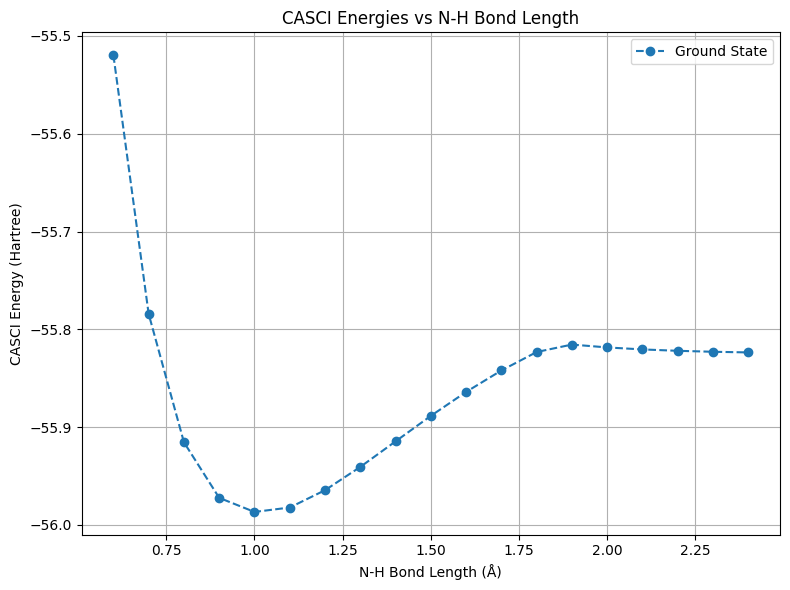

In [1]:
from pyscf import gto, scf, mcscf
import numpy as np

# Define the bond lengths to sweep
bond_lengths = np.linspace(0.6,  2.4, 19) 

# Prepare a list to store the energies
all_energies = []

# Loop over each bond length
for r in bond_lengths:
    # Define the molecule
    mol = gto.M(
        atom=f"N 0.0 0.0 0.0; H {r} 0.0 0.0 ; H -0.506, 0.876, 0.0 ; H -0.506, -0.876, 0.0",
        basis='sto-6g',
        verbose=0
    )

    # Perform Restricted Hartree-Fock calculation
    mf = scf.RHF(mol)
    mf.kernel()

    # Define the active space
    active_orbitals = 4
    active_electrons = 4

    # Set up the CASCI solver (can also use CASSCF if desired)
    mycas = mcscf.CASCI(mf, active_orbitals, active_electrons)
    mycas.fcisolver.nroots = 27  # Compute ground + 4 excited states

    
    # Compute CASCI energies
    e_casci = mycas.kernel()[0]  # kernel() returns (eigenvalues, wavefunctions)
  
    # Append energies (a list of 5 floats) to the master list
    all_energies.append(e_casci)

    # Optionally, print intermediate results
    print(f"Bond length {r:.2f} Å - CASCI energies: {e_casci}")
    nuc_rep_energy = mol.energy_nuc()
    print(f"Bond length {r:.2f} Å - Nuclear repulsion energy: {nuc_rep_energy:.6f} Hartree")



# Convert to NumPy array for later use (e.g., plotting)
all_energies = np.array(all_energies)

# Example: save to a file or inspect
# np.savetxt("casci_energies.txt", all_energies)


import matplotlib.pyplot as plt

# Ensure bond_lengths and all_energies are NumPy arrays
bond_lengths = np.array(bond_lengths)
all_energies = np.array(all_energies)

# Plot each state (column) vs bond length
plt.figure(figsize=(8, 6))
num_states = all_energies.shape[1]

for i in range(num_states):
    if i == 0:
        label = "Ground State"
    else:
        break
        #label = f"Excited State {i}"
    plt.plot(bond_lengths, all_energies[:, i], '--', marker = 'o', label=label)

plt.xlabel("N-H Bond Length (Å)")
plt.ylabel("CASCI Energy (Hartree)")
plt.title("CASCI Energies vs N-H Bond Length")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from pyscf import gto, scf
import pyscf.mcscf as mcscf

mol = gto.M(
    atom = f'N 0 0 0; H 0.6 0 0; H -0.506 0.876 0; H -0.506 -0.876 0',
    basis='sto-6g'
)

mf = scf.RHF(mol).run()

active_electrons = 4
active_orbitals = 4

# Build CASSCF object to expose frozen-core info
mc = mcscf.CASSCF(mf, ncas=active_orbitals, nelecas=active_electrons)
mc.kernel()

frozen_core_energy = mc.e_tot - mc.e_cas
print("Frozen-core energy =", frozen_core_energy)

print("Total energy =", mc.e_cas + frozen_core_energy)



converged SCF energy = -55.5057942666977
CASSCF energy = -55.5198082644266
CASCI E = -55.5198082644266  E(CI) = -5.57685060601536  S^2 = 0.0000000
Frozen-core energy = -49.94295765841126
Total energy = -55.519808264426615
